## Analyzing Ocean Color Imagery

From September 13th cruise on the R/V Shearwater

All ocean color measurements taken manually off the bow using Micasense RedEdge

### Import Shearwater Data

Use pandas library to read the csv

In [1]:
import pandas as pd
df = pd.read_csv("data/130920_shearwatergulf_rededge/Data every 1 min_001.csv")
df.head()

,Date,Time,SW-ZDA-Year,SW-ZDA-Month,SW-ZDA-Day,SW-ZDA-Time,SW-GGA-Lat,SW-GGA-NorS,SW-GGA-Long,SW-GGA-EorW,...,SW-Weather-HumidRel-%,SW-Wind-WindSpeedRel,SW-Wind-WindAngleRel,TrueWind-DRV-SPEED,TrueWind-DRV-DIRECTION,TSG--temp-SBE38,TSG--sal,SW-Depth-DBT-Depth below transducer (m),DepthOverall-DRV-VALUE,Unnamed: 24
0,09/13/2020,11:47:46,2020,9,13,114907.70,3443.0548,N,7640.2341,W,...,89.4,9.39,26.4,9.38,40.19,26.8799,16.5905,5.50,6.50,NaN
1,09/13/2020,11:48:46,2020,9,13,115007.70,3443.0549,N,7640.2341,W,...,89.5,9.99,22.1,9.99,35.71,26.8796,16.5906,5.48,6.48,NaN
2,09/13/2020,11:49:46,2020,9,13,115107.69,3443.0549,N,7640.2341,W,...,89.4,12.79,17.4,13.08,30.48,26.8796,16.5906,5.48,6.48,NaN
3,09/13/2020,11:50:46,2020,9,13,115207.70,3443.0548,N,7640.2338,W,...,89.3,11.39,23.1,11.39,36.70,26.8793,16.5686,5.47,6.47,NaN
4,09/13/2020,11:51:46,2020,9,13,115308.00,3443.0547,N,7640.2339,W,...,89.1,13.39,18.9,13.40,32.57,26.8791,16.5677,5.47,6.47,NaN


Fix the date and time to be a python datetime object for easier plotting

In [2]:
from datetime import datetime

date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]

Convert the dms-ish format to decimal degrees

In [3]:
import numpy as np

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

Convert pandas dataframe to geodataframe with geospatial data incorporated

<AxesSubplot:>

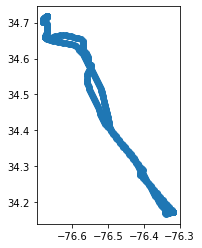

In [4]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.plot()

It is coarse but let's plot it with coastline included from geopandas

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


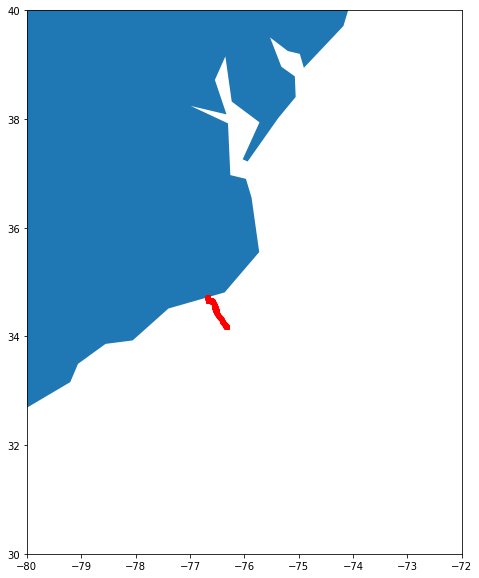

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

ax.set_xlim(-80, -72)
ax.set_ylim(30, 40)

fig.show()

<AxesSubplot:xlabel='lon', ylabel='lat'>

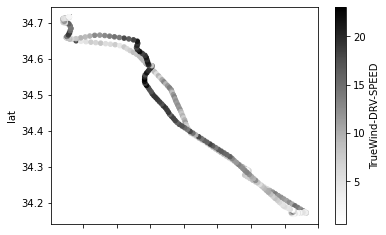

In [6]:
df.plot(kind='scatter',x='lon', y='lat', c='TrueWind-DRV-SPEED', cmap='Greys')

<AxesSubplot:xlabel='lon', ylabel='lat'>

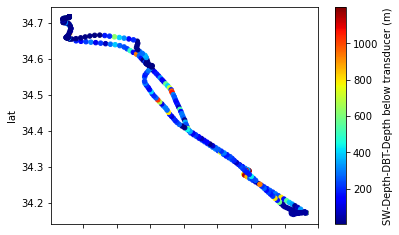

In [7]:
df.plot(kind='scatter',x='lon', y='lat', c='SW-Depth-DBT-Depth below transducer (m)', cmap='jet')

### UAS Ocean Color Data

Read in uas data which was saved as an ESRI shapefile that can be read with geopandas 

In [21]:
chla_gdf = gpd.read_file('uas_data_0014.shp')
chla_gdf.time = pd.to_datetime(chla_gdf.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf.spectra = chla_gdf.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
chla_gdf.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,0.063871,34.247825,-76.384614,"[0.02200393, 0.00789785, 0.00113606, 0.0007810...",2020-09-13 16:33:28,POINT (-76.38461 34.24782)
1,0.063328,34.272481,-76.398839,"[0.02668011, 0.01040405, 0.00151097, 0.0012178...",2020-09-13 16:37:58,POINT (-76.39884 34.27248)
2,0.246177,34.303667,-76.416853,"[0.03596776, 0.01744403, 0.00180694, 0.0011806...",2020-09-13 16:43:35,POINT (-76.41685 34.30367)
3,0.088147,34.253064,-76.387614,"[0.02093576, 0.00810775, 0.00116406, 0.0008980...",2020-09-13 16:34:27,POINT (-76.38761 34.25306)
4,0.321401,34.297428,-76.413183,"[0.03313249, 0.01624155, 0.00177827, 0.0010865...",2020-09-13 16:42:29,POINT (-76.41318 34.29743)


<AxesSubplot:>

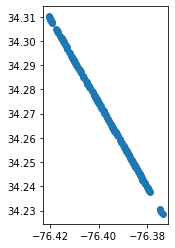

In [24]:
chla_gdf.plot()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


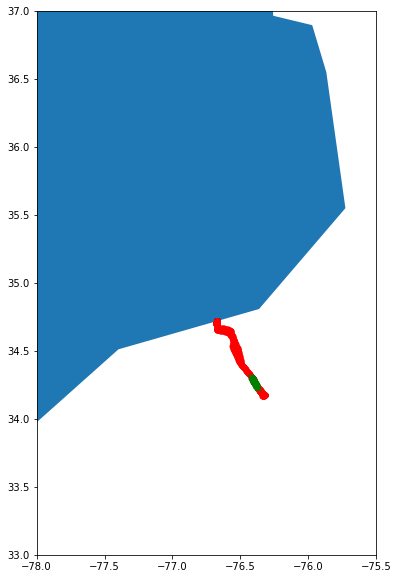

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=25)
chla_gdf.plot(ax=ax, marker='x', color='green', markersize=20)

ax.set_xlim(-78, -75.5)
ax.set_ylim(33, 37)

fig.show()

Text(0.5, 0, 'Time')

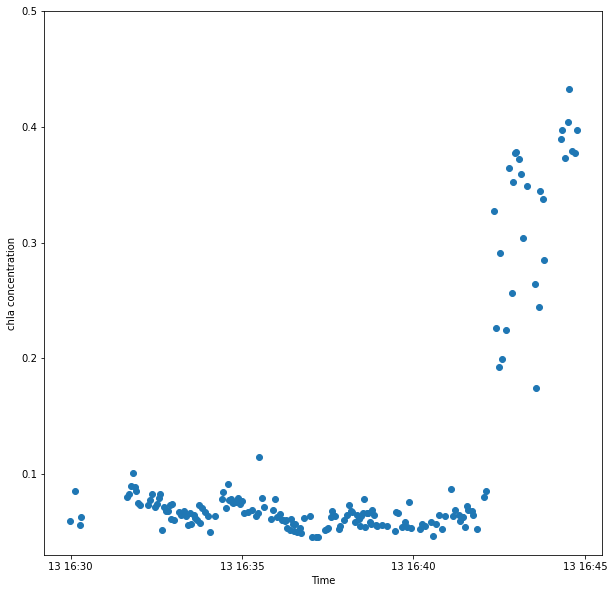

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.set_ylim(0.03,.5)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')

Text(0.5, 0, 'Time')

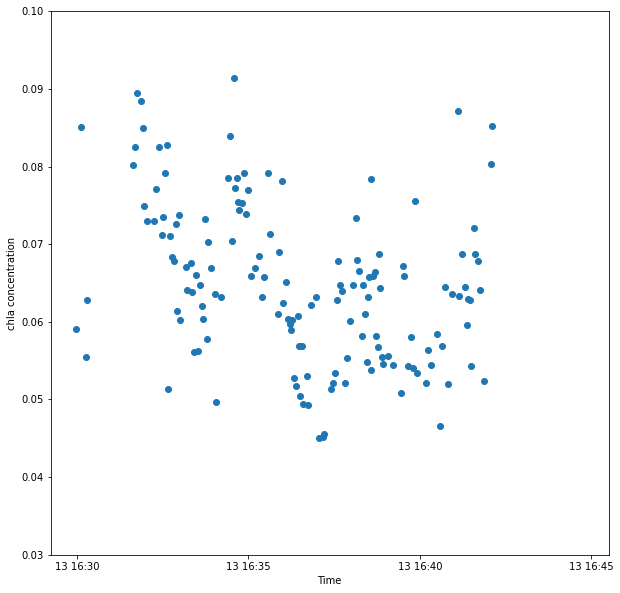

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.set_ylim(0.03,.1)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


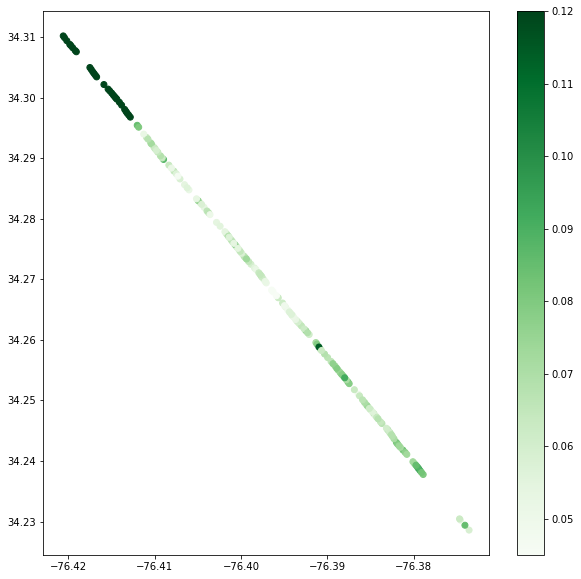

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))

sc = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=0.12)
fig.colorbar(sc)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  after removing the cwd from sys.path.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


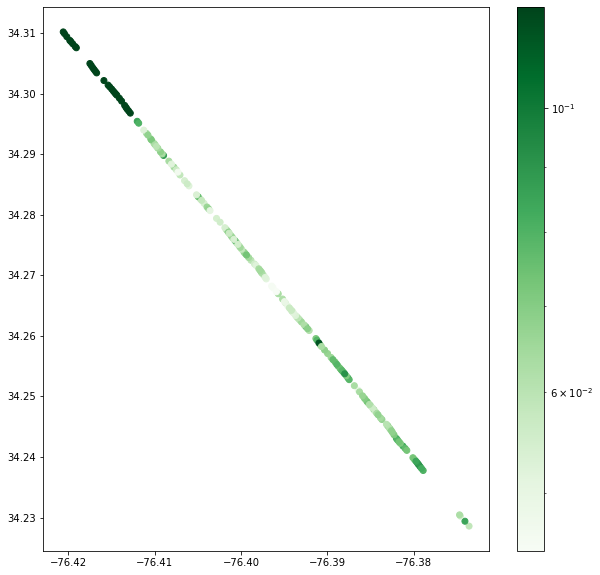

In [57]:
import matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

sc = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=0.12, norm=matplotlib.colors.LogNorm())
fig.colorbar(sc)
fig.show()

### Plot them together

<AxesSubplot:>

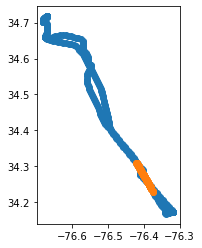

In [88]:
fig, ax = plt.subplots()

gdf.plot(ax=ax)
chla_gdf.plot(ax=ax)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


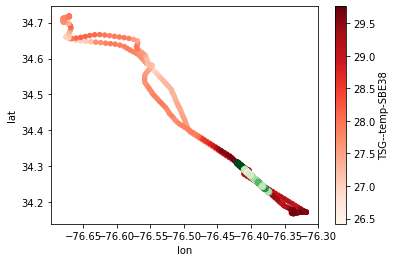

In [61]:
fig, ax = plt.subplots()
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=0.1)
fig.show()

#### Plot chl-a against S and T from the Shearwater

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


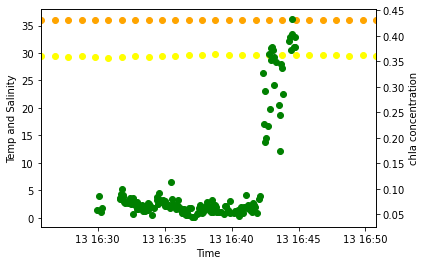

In [62]:
fig, ax = plt.subplots()

ax.set_xlim(datetime.strptime('2020-09-13 16:25:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:50:46', '%Y-%m-%d %H:%M:%S'))

ax2 = ax.twinx()
ax.set_ylabel('Temp and Salinity')
ax.set_xlabel('Time')
ax2.set_ylabel('chla concentration')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--temp-SBE38'], color='yellow')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--sal'], color='orange')
ax2.scatter(x=chla_gdf['time'], y=chla_gdf['chla'], color='green')
fig.show()
